Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[     0      0      0]
 [  1250      0      0]
 [  2500      0      0]
 [  3750      0      0]
 [  5000      0      0]
 [  6250      0      0]
 [  7500      0      0]
 [  8750      0      0]
 [ 10000      0      0]
 [ 11250      0      0]
 [ 12500      0      0]
 [ 13750      0      0]
 [ 15000      0      0]
 [ 16250      0      0]
 [ 17500      0      0]
 [ 18750      0      0]
 [ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 37500      0      0]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000 

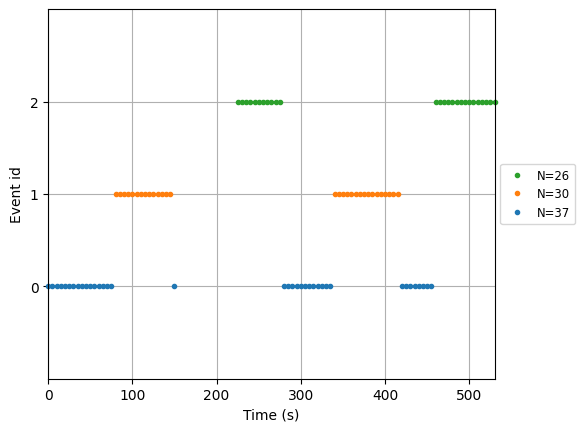

Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Loading data for 93 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
0    37
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
0    17
1    14
2     6
Name: count, dtype: int64
Class distribution in the test set:
2    20
0    20
1    16
Name: count, dtype: int64
Accuracy score: 0.44642857142857145
Confusion Matrix:
[[ 5  7  8]
 [ 2  5  9]
 [ 1  4 15]]


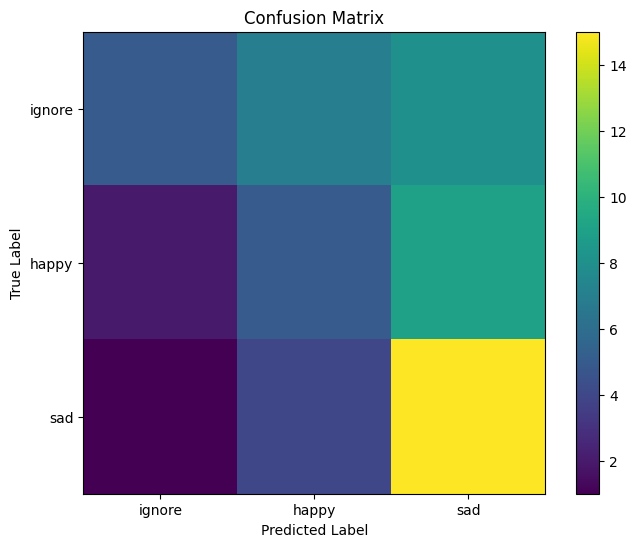

In [1]:
import mne
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations_ignore.csv")
annotations_df['onset'] = annotations_df['onset'] / 1e9


emotional_states = {'happy': 1, 'sad': 2, 'ignore': 0}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


event_id = {'happy': 1, 'sad': 2, 'ignore': 0}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)


def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())

split_idx = int(len(X) * 0.4)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)


y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy score: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.yticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
